## MOD300: mandatory project 4

Participants: Lotte Karlsen Åvitsland and Celina Berg Nøkleby

## Topic 1: Unsupervised learning: Clustering the Milky Way

### Imported packages we use in this project:

In [1]:
import matplotlib.pyplot as plt
from astropy import units as u
from mw_plot import MWSkyMap
from astropy.coordinates import SkyCoord
import numpy as np
from sklearn.cluster import KMeans

import Project4
import importlib
importlib.reload(Project4)

/Users/celina/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


<module 'Project4' from '/Users/celina/Library/CloudStorage/OneDrive-UniversitetetiStavanger/5. semester/MOD300/Project 4/Project4.py'>

We didnt manage to use the original code from PyGaLaXy.ipynb because we got an error at the part of the code where the center was defined when we wrote "M31" so i imported the coordinates (from astropy.coordinates import SkyCoord [[1](#ref1)]), found the coordinates to M31 and used those instead. To find the coordinates we used SkyCoord.from_name() [[2](#ref2)] and got RA and Dec, and to transform them to Galactic we used the built-in frame class **Galactic** [[2](#ref2)]

In [2]:
l_deg_M31, b_deg_M31 = Project4.find_coordinates("M31")
print(l_deg_M31, b_deg_M31)


121.17432903730572 -21.573308797618147


### Task 1

Here we are reproducing the image of the milky way via MWSkyMap

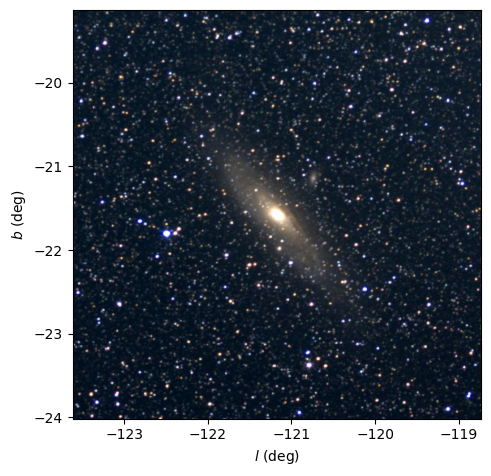

In [3]:
Project4.skymap((-l_deg_M31), b_deg_M31, 8800)

### Task 2

Here we are reproducing the milkyway sector with different centers and radius. First we are using M31 with three different radius, and then using the star Sirius with two different radius.

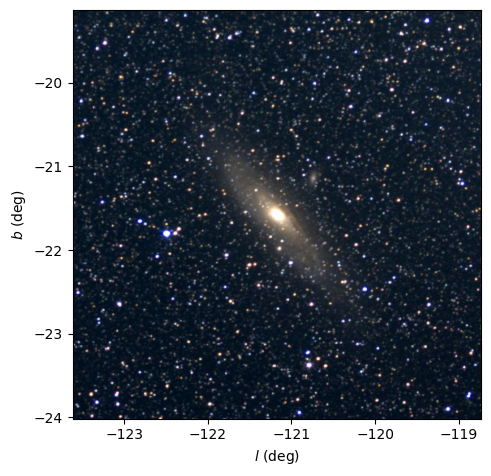

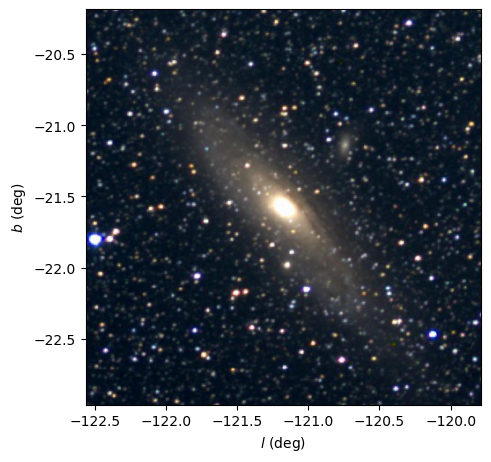

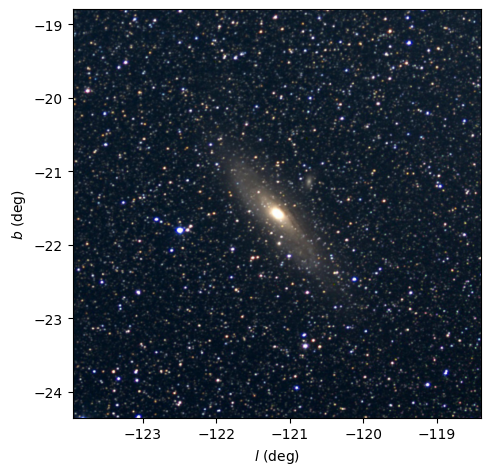

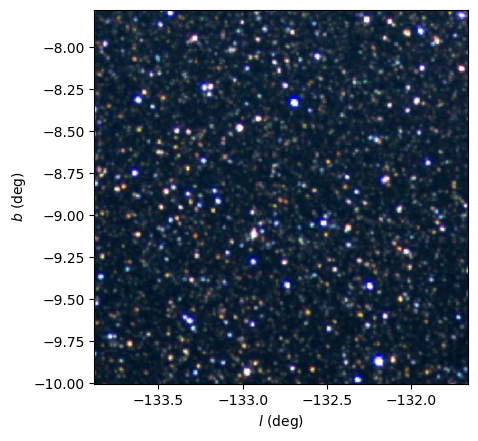

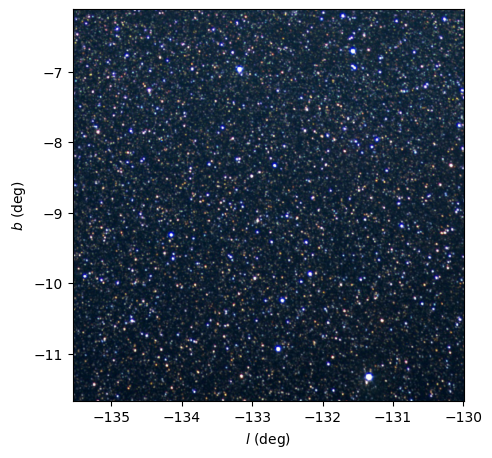

In [4]:
#Different radius M31:
figure_1 = Project4.skymap((-l_deg_M31), b_deg_M31, 8800)
Project4.skymap((-l_deg_M31), b_deg_M31, 5000)
Project4.skymap((-l_deg_M31), b_deg_M31, 10000)


#Center in Sirius
l_deg_Sirius, b_deg_Sirius = Project4.find_coordinates("Sirius")
Project4.skymap((l_deg_Sirius-360), b_deg_Sirius, 4000)
Project4.skymap((l_deg_Sirius-360), b_deg_Sirius, 10000)


### Task 3

Here we are converting the generated image into a rgb np.array. We are also showing the shape of the array and also an example of the RGB in the center of the image.

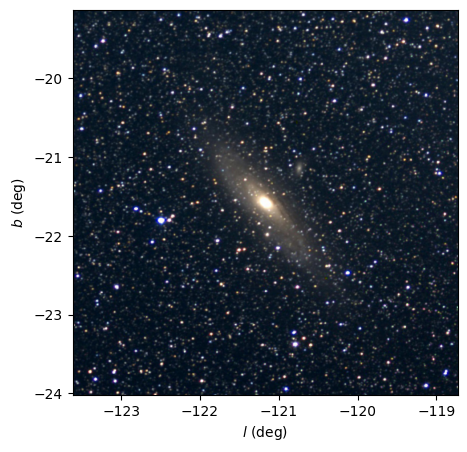

Array (Height, width, color channels) :  (500, 500, 3)


In [5]:
longitude = -121.17432903730572 * u.deg
latitude = -21.573308797618147 * u.deg

mw1 = MWSkyMap(
    center=(longitude, latitude),
    radius=(8800, 8800) * u.arcsec,
    background="Mellinger color optical survey"
)

fig, ax = plt.subplots(figsize=(5, 5))
mw1.transform(ax)
plt.show()

img_array = Project4.plt2rgbarr(fig)

print("Array (Height, width, color channels) : ", img_array.shape)

### Task 4

In this task we are going to describe and generate a set of categories from the task 3 data.

We used the grey = from the PyGaLaXy.ipynb to do this task. We chose to look if it is brighter or darker.

In [6]:
grey = np.sum(img_array[:, :, :] * np.array([0.299, 0.587, 0.114]), axis=2)

brighter = np.where(grey > 200)
darker = np.where(grey <= 200)

print("Brighter points: ",brighter[0].size)
print("Darker points: ", darker[0].size)

Brighter points:  1116
Darker points:  248884


### Task 5

Here we chose to use K-means to cluster the data. (k = 2) [[3](#ref3)]

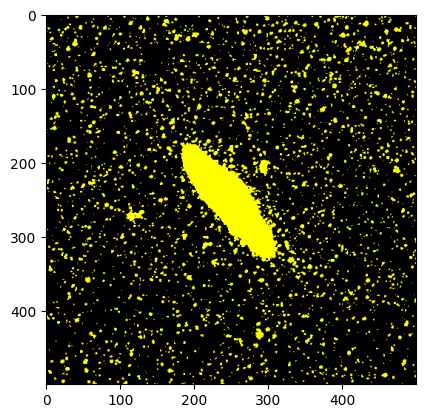

In [7]:
height, width = grey.shape 
X = grey.reshape(-1,1) 
c = X[np.random.choice(len(X),2)] 

for i in range(5): 
    lab = np.argmin(np.abs(X-c.T),1) 
    c = np.array([X[lab==j].mean() for j in (0,1)]) 

L = (lab == np.argmax(c)).reshape(height, width) 
    
RGB = np.zeros((height, width, 3)) 
RGB[L] = (1, 1, 0) 
plt.imshow(RGB) 
plt.show()

### Task 6

Over-impose cluster to the image generated in task 2:

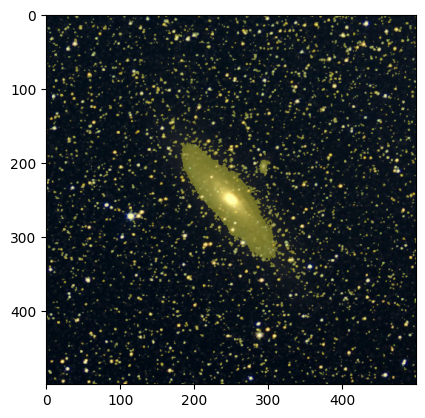

In [8]:
plt.imshow(img_array)
plt.imshow(RGB, alpha = 0.3)
plt.show()

### Task 7

Here we added a category to task 4. We chose to add one more category so the brightness is now divided into three categories: brighter, middle bright and darker.

In [9]:
grey = np.sum(img_array[:, :, :] * np.array([0.299, 0.587, 0.114]), axis=2)

brighter = np.where(grey > 100)
middle = np.where((100 < grey) & (grey < 200 ))
darker = np.where(grey < 200)

print("Brighter points: ",brighter[0].size)
print("Middle bright points: ", middle[0].size)
print("Darker points: ", darker[0].size)


Brighter points:  7112
Middle bright points:  5996
Darker points:  248884


As we can see from our results is that when adding one more category we got fewer daker points, so the new one is more accurate than the first one we made with only two categories.

## TOPIC 2: Supervised learning: Machines versus human models, who can save the world??

In [10]:
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

### Task 0

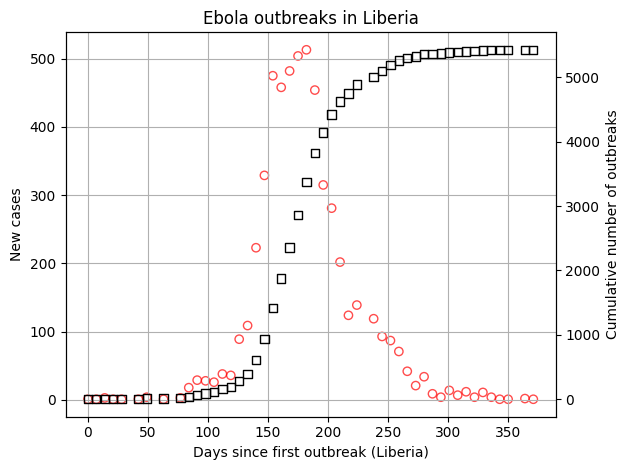

In [11]:
data = np.loadtxt("ebola_cases_liberia.dat", skiprows=1, usecols=(1, 2))

days = data[:, 0]
new_cases = data[:, 1]
cum_cases = np.cumsum(new_cases)

fig, ax1 = plt.subplots()
ax1.scatter(days, new_cases, color = 'red', facecolors = 'none', marker = 'o', alpha=0.7, label="New cases")

ax1.set_xlabel("Days since first outbreak (Liberia)")
ax1.set_ylabel("New cases")

ax2 = ax1.twinx()
ax2.scatter(days, cum_cases, edgecolor = 'black', facecolor = 'none', marker = 's', label="Cumulative")
ax2.set_ylabel("Cumulative number of outbreaks")

plt.title("Ebola outbreaks in Liberia")
ax1.grid(True)

plt.tight_layout(); plt.show()

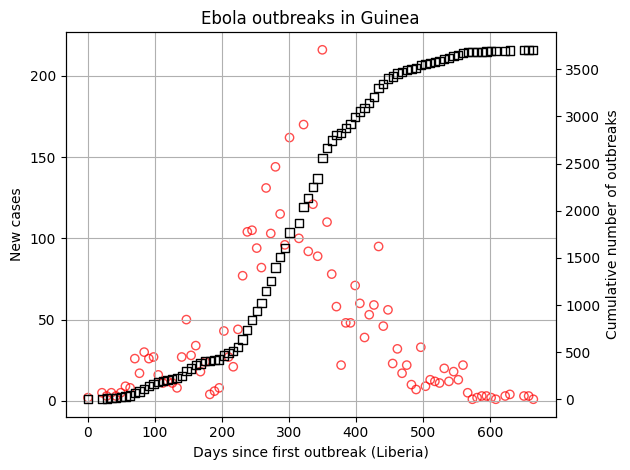

In [12]:
data = np.loadtxt("ebola_cases_guinea.dat", skiprows=1, usecols=(1, 2))

days = data[:, 0]
new_cases = data[:, 1]
cum_cases = np.cumsum(new_cases)

fig, ax1 = plt.subplots()
ax1.scatter(days, new_cases, color = 'red', facecolors = 'none', marker = 'o', alpha=0.7, label="New cases")

ax1.set_xlabel("Days since first outbreak (Liberia)")
ax1.set_ylabel("New cases")

ax2 = ax1.twinx()
ax2.scatter(days, cum_cases, edgecolor = 'black', facecolor = 'none', marker = 's', label="Cumulative")
ax2.set_ylabel("Cumulative number of outbreaks")

plt.title("Ebola outbreaks in Guinea")
ax1.grid(True)

plt.tight_layout(); plt.show()

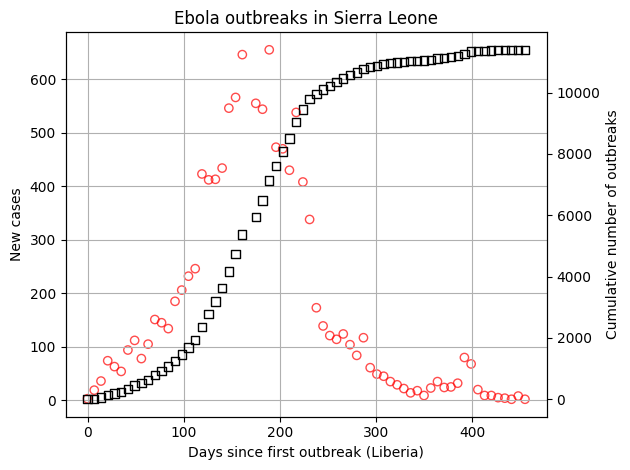

In [13]:
data = np.loadtxt("ebola_cases_sierra_leone.dat", skiprows=1, usecols=(1, 2))

days = data[:, 0]
new_cases = data[:, 1]
cum_cases = np.cumsum(new_cases)

fig, ax1 = plt.subplots()
ax1.scatter(days, new_cases, color = 'red', facecolors = 'none', marker = 'o', alpha=0.7, label="New cases")

ax1.set_xlabel("Days since first outbreak (Liberia)")
ax1.set_ylabel("New cases")

ax2 = ax1.twinx()
ax2.scatter(days, cum_cases, edgecolor = 'black', facecolor = 'none', marker = 's', label="Cumulative")
ax2.set_ylabel("Cumulative number of outbreaks")

plt.title("Ebola outbreaks in Sierra Leone")
ax1.grid(True)

plt.tight_layout(); plt.show()

### Task 1

In this task we use linear regression to fit the data on ebola outbreaks in the three different countries. We plot the days after the outbreak on the X axis and the cummulative number of outbreaks on the Y axis

[[  0.]
 [  7.]
 [ 14.]
 [ 21.]
 [ 28.]
 [ 42.]
 [ 49.]
 [ 63.]
 [ 77.]
 [ 84.]
 [ 91.]
 [ 98.]
 [105.]
 [112.]
 [119.]
 [126.]
 [133.]
 [140.]
 [147.]
 [154.]
 [161.]
 [168.]
 [175.]
 [182.]
 [189.]
 [196.]
 [203.]
 [210.]
 [217.]
 [224.]
 [238.]
 [245.]
 [252.]
 [259.]
 [266.]
 [273.]
 [280.]
 [287.]
 [294.]
 [301.]
 [308.]
 [315.]
 [322.]
 [329.]
 [336.]
 [343.]
 [350.]
 [364.]
 [371.]]
[[1.000e+00]
 [2.000e+00]
 [5.000e+00]
 [6.000e+00]
 [7.000e+00]
 [8.000e+00]
 [1.200e+01]
 [1.300e+01]
 [1.600e+01]
 [3.400e+01]
 [6.300e+01]
 [9.100e+01]
 [1.170e+02]
 [1.550e+02]
 [1.910e+02]
 [2.800e+02]
 [3.890e+02]
 [6.120e+02]
 [9.410e+02]
 [1.416e+03]
 [1.874e+03]
 [2.356e+03]
 [2.860e+03]
 [3.373e+03]
 [3.827e+03]
 [4.142e+03]
 [4.423e+03]
 [4.625e+03]
 [4.749e+03]
 [4.888e+03]
 [5.007e+03]
 [5.100e+03]
 [5.187e+03]
 [5.258e+03]
 [5.300e+03]
 [5.321e+03]
 [5.355e+03]
 [5.364e+03]
 [5.368e+03]
 [5.382e+03]
 [5.389e+03]
 [5.401e+03]
 [5.405e+03]
 [5.416e+03]
 [5.420e+03]
 [5.421e+03]
 [5.422e+

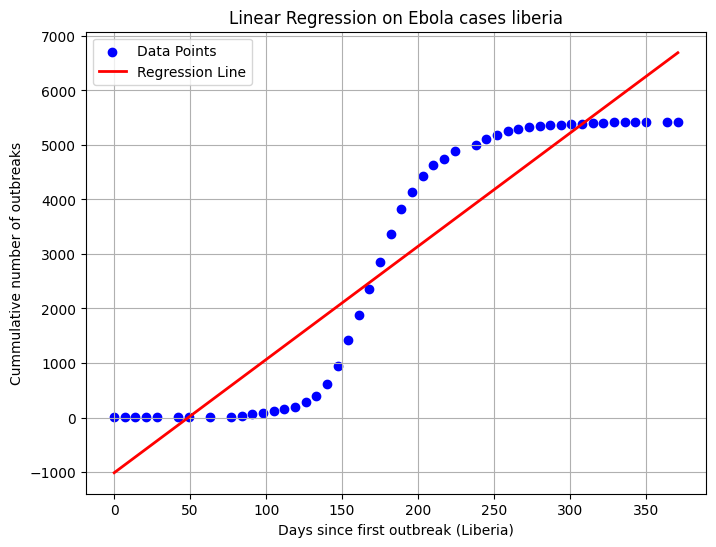

In [14]:
data = np.loadtxt("ebola_cases_liberia.dat", skiprows=1, usecols=(1, 2))

X = data[:, 0]
new_cases = data[:, 1]
Y = np.cumsum(new_cases)

reshaped_array_result_1 = np.reshape(X, (-1, 1))
print(reshaped_array_result_1) #Check that it becomes a 2D array

reshaped_array_result_2 = np.reshape(Y, (-1, 1))
print(reshaped_array_result_2)

model = LinearRegression()
model.fit(reshaped_array_result_1, reshaped_array_result_2) 

Y_pred = model.predict(reshaped_array_result_1)

plt.figure(figsize=(8,6)) 
plt.scatter(reshaped_array_result_1, reshaped_array_result_2, color='blue', label='Data Points') 
plt.plot(reshaped_array_result_1, Y_pred, color='red', linewidth=2, label='Regression Line') 
plt.title('Linear Regression on Ebola cases liberia')
plt.xlabel('Days since first outbreak (Liberia)')
plt.ylabel('Cummulative number of outbreaks')
plt.legend()
plt.grid(True)
plt.show()

[[  0.]
 [ 21.]
 [ 28.]
 [ 35.]
 [ 42.]
 [ 49.]
 [ 56.]
 [ 63.]
 [ 70.]
 [ 77.]
 [ 84.]
 [ 91.]
 [ 98.]
 [105.]
 [112.]
 [119.]
 [126.]
 [133.]
 [140.]
 [147.]
 [154.]
 [161.]
 [168.]
 [175.]
 [182.]
 [189.]
 [196.]
 [203.]
 [210.]
 [217.]
 [224.]
 [231.]
 [238.]
 [245.]
 [252.]
 [259.]
 [266.]
 [273.]
 [280.]
 [287.]
 [294.]
 [301.]
 [315.]
 [322.]
 [329.]
 [336.]
 [343.]
 [350.]
 [357.]
 [364.]
 [371.]
 [378.]
 [385.]
 [392.]
 [399.]
 [406.]
 [413.]
 [420.]
 [427.]
 [434.]
 [441.]
 [448.]
 [455.]
 [462.]
 [469.]
 [476.]
 [483.]
 [490.]
 [497.]
 [504.]
 [511.]
 [518.]
 [525.]
 [532.]
 [539.]
 [546.]
 [553.]
 [560.]
 [567.]
 [574.]
 [581.]
 [588.]
 [595.]
 [602.]
 [609.]
 [623.]
 [630.]
 [651.]
 [658.]
 [665.]]
[[2.000e+00]
 [7.000e+00]
 [1.000e+01]
 [1.500e+01]
 [1.800e+01]
 [2.300e+01]
 [3.200e+01]
 [4.000e+01]
 [6.600e+01]
 [8.300e+01]
 [1.130e+02]
 [1.390e+02]
 [1.660e+02]
 [1.820e+02]
 [1.930e+02]
 [2.050e+02]
 [2.160e+02]
 [2.240e+02]
 [2.510e+02]
 [3.010e+02]
 [3.290e+02]
 [3.63

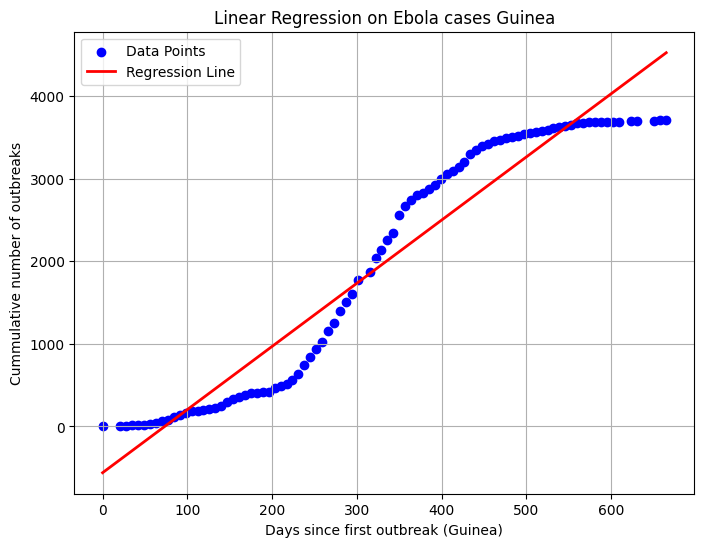

In [15]:
data = np.loadtxt("ebola_cases_guinea.dat", skiprows=1, usecols=(1, 2))

X = data[:, 0]
new_cases = data[:, 1]
Y = np.cumsum(new_cases)

reshaped_array_result_1 = np.reshape(X, (-1, 1))
print(reshaped_array_result_1) #Check that it becomes a 2D array

reshaped_array_result_2 = np.reshape(Y, (-1, 1))
print(reshaped_array_result_2)

model = LinearRegression()
model.fit(reshaped_array_result_1, reshaped_array_result_2) 

Y_pred = model.predict(reshaped_array_result_1)

plt.figure(figsize=(8,6)) 
plt.scatter(reshaped_array_result_1, reshaped_array_result_2, color='blue', label='Data Points') 
plt.plot(reshaped_array_result_1, Y_pred, color='red', linewidth=2, label='Regression Line') 
plt.title('Linear Regression on Ebola cases Guinea')
plt.xlabel('Days since first outbreak (Guinea)')
plt.ylabel('Cummulative number of outbreaks')
plt.legend()
plt.grid(True)
plt.show()

[[  0.]
 [  7.]
 [ 14.]
 [ 21.]
 [ 28.]
 [ 35.]
 [ 42.]
 [ 49.]
 [ 56.]
 [ 63.]
 [ 70.]
 [ 77.]
 [ 84.]
 [ 91.]
 [ 98.]
 [105.]
 [112.]
 [119.]
 [126.]
 [133.]
 [140.]
 [147.]
 [154.]
 [161.]
 [175.]
 [182.]
 [189.]
 [196.]
 [203.]
 [210.]
 [217.]
 [224.]
 [231.]
 [238.]
 [245.]
 [252.]
 [259.]
 [266.]
 [273.]
 [280.]
 [287.]
 [294.]
 [301.]
 [308.]
 [315.]
 [322.]
 [329.]
 [336.]
 [343.]
 [350.]
 [357.]
 [364.]
 [371.]
 [378.]
 [385.]
 [392.]
 [399.]
 [406.]
 [413.]
 [420.]
 [427.]
 [434.]
 [441.]
 [448.]
 [455.]]
[[3.0000e+00]
 [2.2000e+01]
 [5.8000e+01]
 [1.3200e+02]
 [1.9500e+02]
 [2.4900e+02]
 [3.4300e+02]
 [4.5500e+02]
 [5.3300e+02]
 [6.3800e+02]
 [7.8900e+02]
 [9.3400e+02]
 [1.0680e+03]
 [1.2530e+03]
 [1.4590e+03]
 [1.6910e+03]
 [1.9370e+03]
 [2.3600e+03]
 [2.7720e+03]
 [3.1850e+03]
 [3.6190e+03]
 [4.1650e+03]
 [4.7310e+03]
 [5.3770e+03]
 [5.9320e+03]
 [6.4760e+03]
 [7.1310e+03]
 [7.6040e+03]
 [8.0740e+03]
 [8.5040e+03]
 [9.0420e+03]
 [9.4500e+03]
 [9.7880e+03]
 [9.9610e+03]
 [1

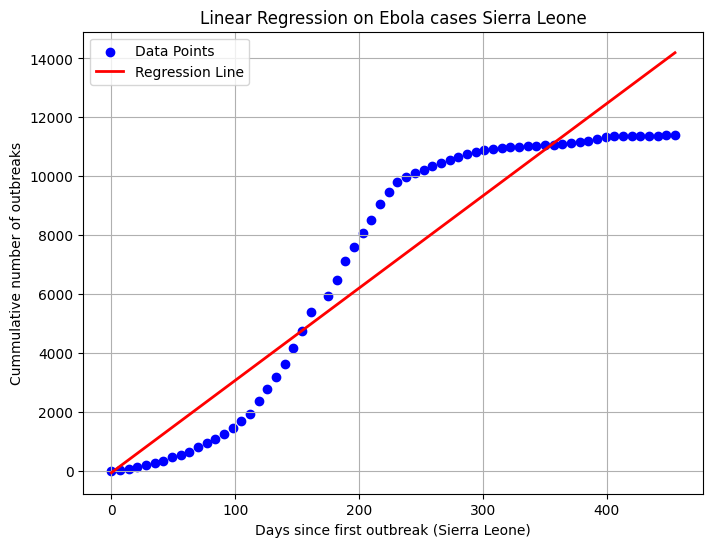

In [16]:
data = np.loadtxt("ebola_cases_sierra_leone.dat", skiprows=1, usecols=(1, 2))

X = data[:, 0]
new_cases = data[:, 1]
Y = np.cumsum(new_cases)

reshaped_array_result_1 = np.reshape(X, (-1, 1))
print(reshaped_array_result_1) #Check that it becomes a 2D array

reshaped_array_result_2 = np.reshape(Y, (-1, 1))
print(reshaped_array_result_2)

model = LinearRegression()
model.fit(reshaped_array_result_1, reshaped_array_result_2) 

Y_pred = model.predict(reshaped_array_result_1)

plt.figure(figsize=(8,6)) 
plt.scatter(reshaped_array_result_1, reshaped_array_result_2, color='blue', label='Data Points') 
plt.plot(reshaped_array_result_1, Y_pred, color='red', linewidth=2, label='Regression Line') 
plt.title('Linear Regression on Ebola cases Sierra Leone')
plt.xlabel('Days since first outbreak (Sierra Leone)')
plt.ylabel('Cummulative number of outbreaks')
plt.legend()
plt.grid(True)
plt.show()

### Task 2

From the figures generated in task 0, we can see that the cummulative number of outbreaks grows very fast in the beginning of the epidemic and then slow down, creating almost an S like shape common for logistic functions, where something grows really fast in the beginning but then slows down after reaching a certain point. Given the shape we will try a logistic fit for the data in the three countries to see if it fits better then the linear regression. Given by: $$ y = \frac{L}{1+ e^{-k(x-x_0)}} $$

/var/folders/cn/5cnfsx8s6md_rckzchhhnwqc0000gn/T/ipykernel_16510/2088882041.py:9: RuntimeWarning: overflow encountered in exp
  return L / (1 + np.exp(-k*(X - X0)))


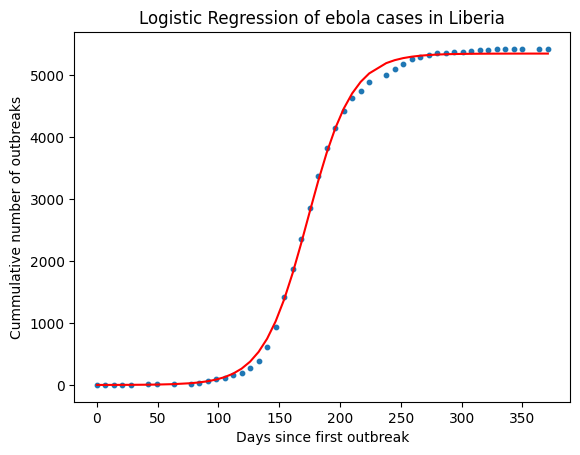

In [17]:
data = np.loadtxt("ebola_cases_liberia.dat", skiprows=1, usecols=(1, 2))

X = data[:, 0]
new_cases = data[:, 1]
Y = np.cumsum(new_cases)


def logistic(X, L, k, X0):
    return L / (1 + np.exp(-k*(X - X0)))

params, _ = curve_fit(logistic, X, Y, p0=[1, 1, 1])


plt.scatter(X, Y, s=10)
plt.plot(X, logistic(X, *params), color='red')
plt.title("Logistic Regression of ebola cases in Liberia")
plt.xlabel('Days since first outbreak')
plt.ylabel('Cummulative number of outbreaks')
plt.show()

/var/folders/cn/5cnfsx8s6md_rckzchhhnwqc0000gn/T/ipykernel_16510/2099506789.py:9: RuntimeWarning: overflow encountered in exp
  return L / (1 + np.exp(-k*(X - X0)))


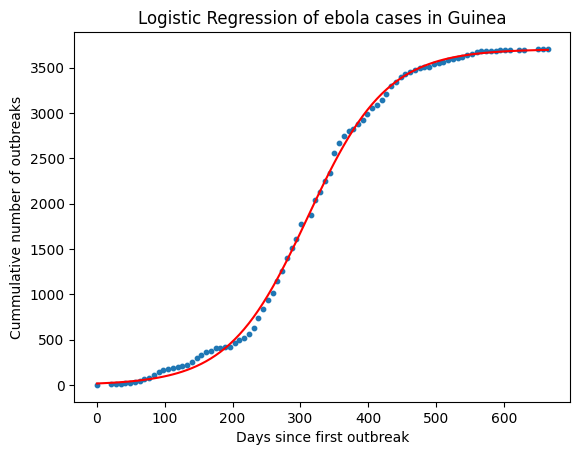

In [18]:
data = np.loadtxt("ebola_cases_guinea.dat", skiprows=1, usecols=(1, 2))

X = data[:, 0]
new_cases = data[:, 1]
Y = np.cumsum(new_cases)


def logistic(X, L, k, X0):
    return L / (1 + np.exp(-k*(X - X0)))

params, _ = curve_fit(logistic, X, Y, p0=[3500, 1, 300])


plt.scatter(X, Y, s=10)
plt.plot(X, logistic(X, *params), color='red')
plt.title("Logistic Regression of ebola cases in Guinea")
plt.xlabel('Days since first outbreak')
plt.ylabel('Cummulative number of outbreaks')
plt.show()

/var/folders/cn/5cnfsx8s6md_rckzchhhnwqc0000gn/T/ipykernel_16510/2790804269.py:9: RuntimeWarning: overflow encountered in exp
  return L / (1 + np.exp(-k*(X - X0)))


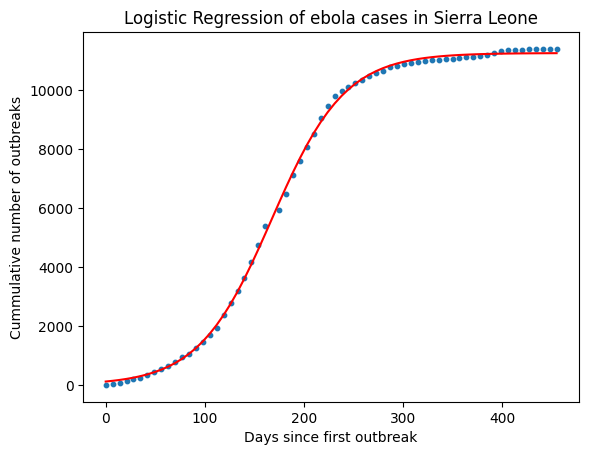

In [19]:
data = np.loadtxt("ebola_cases_sierra_leone.dat", skiprows=1, usecols=(1, 2))

X = data[:, 0]
new_cases = data[:, 1]
Y = np.cumsum(new_cases)


def logistic(X, L, k, X0):
    return L / (1 + np.exp(-k*(X - X0)))

params, _ = curve_fit(logistic, X, Y, p0=[12000, 1, 200])


plt.scatter(X, Y, s=10)
plt.plot(X, logistic(X, *params), color='red')
plt.title("Logistic Regression of ebola cases in Sierra Leone")
plt.xlabel('Days since first outbreak')
plt.ylabel('Cummulative number of outbreaks')
plt.show()

These graphs fit a lot better to our outbreak data then the linear regression.

### Task 3

In [20]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

data = np.loadtxt("ebola_cases_liberia.dat", skiprows=1, usecols=(1, 2))

X = data[:, 0]
new_cases = data[:, 1]
Y = np.cumsum(new_cases)

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_x.fit_transform(X.reshape(-1, 1))
Y_scaled = scaler_y.fit_transform(Y.reshape(-1, 1))

split = int(len(X_scaled) * 0.7)

X_train = X_scaled[:split]
Y_train = Y_scaled[:split]

X_test = X_scaled[split:]
Y_test = Y_scaled[split:]

#Define the neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(1,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  #Output layer without activation for linear regression
])

#Compile the model
model.compile(optimizer= Adam(learning_rate=0.001),
              loss = 'mse')

history = model.fit(
    X_train, Y_train,
    epochs = 2000,
    batch_size = 16,
    validation_data = (X_test, Y_test),
    verbose = 0,
    shuffle = False
)

Y_pred_scaled = model.predict(X_scaled)
Y_pred = scaler_y.inverse_transform(Y_pred_scaled)

plt.figure(figsize=(6, 4))
plt.scatter(X, Y, s=20, label='Original data')
plt.plot(X, Y_pred, 'r', label= 'NN Prediction')
plt.xlabel('Days since first outbreak')
plt.ylabel('Cumulative number of outbreaks')
plt.legend()
plt.tight_layout()
plt.show()

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
data = np.loadtxt("ebola_cases_guinea.dat", skiprows=1, usecols=(1, 2))

X = data[:, 0]
new_cases = data[:, 1]
Y = np.cumsum(new_cases)

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_x.fit_transform(X.reshape(-1, 1))
Y_scaled = scaler_y.fit_transform(Y.reshape(-1, 1))

split = int(len(X_scaled) * 0.7)

X_train = X_scaled[:split]
Y_train = Y_scaled[:split]

X_test = X_scaled[split:]
Y_test = Y_scaled[split:]

#Define the neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(1,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  #Output layer without activation for linear regression
])

#Compile the model
model.compile(optimizer= Adam(learning_rate=0.001),
              loss = 'mse')

history = model.fit(
    X_train, Y_train,
    epochs = 2000,
    batch_size = 16,
    validation_data = (X_test, Y_test),
    verbose = 0,
    shuffle = False
)

Y_pred_scaled = model.predict(X_scaled)
Y_pred = scaler_y.inverse_transform(Y_pred_scaled)

plt.figure(figsize=(6, 4))
plt.scatter(X, Y, s=20, label='Original data')
plt.plot(X, Y_pred, 'r', label= 'NN Prediction')
plt.xlabel('Days since first outbreak')
plt.ylabel('Cumulative number of outbreaks')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
data = np.loadtxt("ebola_cases_sierra_leone.dat", skiprows=1, usecols=(1, 2))

X = data[:, 0]
new_cases = data[:, 1]
Y = np.cumsum(new_cases)

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_x.fit_transform(X.reshape(-1, 1))
Y_scaled = scaler_y.fit_transform(Y.reshape(-1, 1))

split = int(len(X_scaled) * 0.7)

X_train = X_scaled[:split]
Y_train = Y_scaled[:split]

X_test = X_scaled[split:]
Y_test = Y_scaled[split:]

#Define the neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(1,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  #Output layer without activation for linear regression
])
#Compile the model
model.compile(optimizer= Adam(learning_rate=0.001),
              loss = 'mse')

history = model.fit(
    X_train, Y_train,
    epochs = 2000,
    batch_size = 16,
    validation_data = (X_test, Y_test),
    verbose = 0,
    shuffle = False
)

Y_pred_scaled = model.predict(X_scaled)
Y_pred = scaler_y.inverse_transform(Y_pred_scaled)

plt.figure(figsize=(6, 4))
plt.scatter(X, Y, s=20, label='Original data')
plt.plot(X, Y_pred, 'r', label= 'NN Prediction')
plt.xlabel('Days since first outbreak')
plt.ylabel('Cumulative number of outbreaks')
plt.legend()
plt.tight_layout()
plt.show()

### Task 4

In [ ]:
from tensorflow.keras.layers import LSTM

data = np.loadtxt("ebola_cases_liberia.dat", skiprows=1, usecols=(1, 2))

X_days = data[:, 0]
new_cases = data[:, 1]
Y_cum = np.cumsum(new_cases)

scaler_y = MinMaxScaler()
Y_scaled = scaler_y.fit_transform(Y_cum.reshape(-1, 1))

def create_sequences(series, look_back=5):
    X_seq, y_seq = [], []
    for i in range (len(series)- look_back):
        X_seq.append(series[i:i+look_back])
        y_seq.append(series[i+look_back])
    return np.array(X_seq), np.array(y_seq)


look_back = 5
X_seq, y_seq = create_sequences(Y_scaled, look_back)

X_seq = X_seq.reshape((X_seq.shape[0], X_seq.shape[1], 1))

split = int(len(X_scaled) * 0.7)
X_train, X_test = X_seq[:split], X_seq[split:]
Y_train, Y_test = y_seq[:split], y_seq[split:]

model = Sequential([
    LSTM(50, activation='tanh', input_shape= (look_back, 1)),
    Dense(1)
])

model.compile(optimizer= 'adam', loss = 'mse')

history = model.fit(
    X_train, Y_train,
    epochs = 300,
    batch_size = 16,
    validation_data = (X_test, Y_test),
    verbose = 0,
    shuffle = False
)


Y_pred_scaled = model.predict(X_seq)
Y_pred = scaler_y.inverse_transform(Y_pred_scaled)

days_pred = X_days[look_back:]

plt.figure(figsize=(6, 4))
plt.scatter(X_days, Y_cum, s=20, label='Original data')
plt.plot(days_pred, Y_pred.flatten(), 'r', label= 'LSTM Prediction')
plt.xlabel('Days since first outbreak')
plt.ylabel('Cumulative number of outbreaks')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
data = np.loadtxt("ebola_cases_guinea.dat", skiprows=1, usecols=(1, 2))

X_days = data[:, 0]
new_cases = data[:, 1]
Y_cum = np.cumsum(new_cases)

scaler_y = MinMaxScaler()
Y_scaled = scaler_y.fit_transform(Y_cum.reshape(-1, 1))

def create_sequences(series, look_back=5):
    X_seq, y_seq = [], []
    for i in range (len(series)- look_back):
        X_seq.append(series[i:i+look_back])
        y_seq.append(series[i+look_back])
    return np.array(X_seq), np.array(y_seq)


look_back = 5
X_seq, y_seq = create_sequences(Y_scaled, look_back)

X_seq = X_seq.reshape((X_seq.shape[0], X_seq.shape[1], 1))

split = int(len(X_scaled) * 0.7)
X_train, X_test = X_seq[:split], X_seq[split:]
Y_train, Y_test = y_seq[:split], y_seq[split:]

model = Sequential([
    LSTM(50, activation='tanh', input_shape= (look_back, 1)),
    Dense(1)
])

model.compile(optimizer= 'adam', loss = 'mse')

history = model.fit(
    X_train, Y_train,
    epochs = 300,
    batch_size = 16,
    validation_data = (X_test, Y_test),
    verbose = 0,
    shuffle = False
)


Y_pred_scaled = model.predict(X_seq)
Y_pred = scaler_y.inverse_transform(Y_pred_scaled)

days_pred = X_days[look_back:]

plt.figure(figsize=(6, 4))
plt.scatter(X_days, Y_cum, s=20, label='Original data')
plt.plot(days_pred, Y_pred.flatten(), 'r', label= 'LSTM Prediction')
plt.xlabel('Days since first outbreak')
plt.ylabel('Cumulative number of outbreaks')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
data = np.loadtxt("ebola_cases_sierra_leone.dat", skiprows=1, usecols=(1, 2))

X_days = data[:, 0]
new_cases = data[:, 1]
Y_cum = np.cumsum(new_cases)

scaler_y = MinMaxScaler()
Y_scaled = scaler_y.fit_transform(Y_cum.reshape(-1, 1))

def create_sequences(series, look_back=5):
    X_seq, y_seq = [], []
    for i in range (len(series)- look_back):
        X_seq.append(series[i:i+look_back])
        y_seq.append(series[i+look_back])
    return np.array(X_seq), np.array(y_seq)


look_back = 5
X_seq, y_seq = create_sequences(Y_scaled, look_back)

X_seq = X_seq.reshape((X_seq.shape[0], X_seq.shape[1], 1))

split = int(len(X_scaled) * 0.7)
X_train, X_test = X_seq[:split], X_seq[split:]
Y_train, Y_test = y_seq[:split], y_seq[split:]

model = Sequential([
    LSTM(50, activation='tanh', input_shape= (look_back, 1)),
    Dense(1)
])

model.compile(optimizer= 'adam', loss = 'mse')

history = model.fit(
    X_train, Y_train,
    epochs = 300,
    batch_size = 16,
    validation_data = (X_test, Y_test),
    verbose = 0,
    shuffle = False
)


Y_pred_scaled = model.predict(X_seq)
Y_pred = scaler_y.inverse_transform(Y_pred_scaled)

days_pred = X_days[look_back:]

plt.figure(figsize=(6, 4))
plt.scatter(X_days, Y_cum, s=20, label='Original data')
plt.plot(days_pred, Y_pred.flatten(), 'r', label= 'LSTM Prediction')
plt.xlabel('Days since first outbreak')
plt.ylabel('Cumulative number of outbreaks')
plt.legend()
plt.tight_layout()
plt.show()

### Task 5

In task 3 when we use a Neural Network that is not specialized for time series, we see that the prediction is a bit off on the end. The predicted epidemic shows that there will be more outbreaks than there actually will be. With the LSTM prediction we get a more accurate prediction of how the epidemic will evolve. This is because it can capture long-term dependencies better. Machine learning could be used to get an idea of how epidemics or any given situation will evolve but not trusted 100%. It can give an idea so that one can be prepared for that situation. It can also be inaccurate if there is a sudden change in the data in ths case in the amount of outbreaks, because the prediction relies on the previous info it has been fed, so if there is a sudden big change in the data it will be hard to predict through machine learning.

## Other requirements

**Task distribution:**

Topic 1: Celina

Topic 2: Lotte

We used Ai for this project to help us with errors. In topic 1, task 5 we had to use AI to help us with some errors. We couldnt get the plot to show correctly, it would only go comletly yellow or black so AI helped us with fixing our code here. 

In topic 2 we used AI in task 3 and 4 when we used a neural network to predict the data. In task 3 we used AI to help define what model to use with the sequential function and fit, so that the prediction did not become linear but more accurately fitted for our data. Also we used it for help to normalize the values so we did not get an error when running the code. In task 4 we used AI for help with the inverse transform as well.

Self reflection: 
Topic 1: This was a really fun task to do. It was nice to learn how to use external libraries, and visuilize data. And to make an image into a numerical array was interesting. And it was also interesting to apply K-means. But we did not like that all the projects was so different from each other, project 1 and 2 had incredibly good setup and we understood what the teacher was looking for and how we should do things, but on the two last projects it was not as clear at all. It felt like we had two different classes.

Topic 2: It was interesting to see how with the data we have we can predict how epidemics will evolve. It was also interesting to learn model fitting for the data to see which model fit the best to our data, in comparison to linear regression. It was interesting to see how accurate the NN prediction could be with the LSTM approach and we learned how to normalize values, and "feed" the NN with information so it could predict the behaviour further. 

<a id="ref1"></a>[1] https://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html

<a id="ref2"></a>[2] https://docs.astropy.org/en/stable/coordinates/index.html

<a id="ref3"></a>[3] https://www.geeksforgeeks.org/machine-learning/k-means-clustering-introduction/